In [1]:
#!/usr/bin/env python3
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List
import matplotlib.pyplot as plt


class char_tokenizer:
    """
    a very simple char-based tokenizer. the tokenizer turns a string into a list of integers.
    """

    def __init__(self, corpus: List[str]):
        self.corpus = corpus
        # TODO: calculate the vocab size and create a dictionary that maps each character to a unique integer
        self.n_vocab = len(corpus)
        self.char2int = {char: i for i, char in enumerate(corpus)}
        # End of your code

    def encode(self, string: str):
        # TODO: convert a string into a list of integers and return, using the dictionary you created above
        return [self.char2int[char] for char in string]
        # End of your code

    def decode(self, codes: List[int]):
        # TODO: convert a list of integers into a string and return, using the dictionary you created above
        return ''.join([self.corpus[code] for code in codes])
        # End of your code


class Head(nn.Module):
    """single head of self-attention"""

    def __init__(self, head_size):
        super().__init__()
        # TODO: create three linear layers, Key, Query, and Value, each of which maps from n_embd to head_size
        #       and assign them to self.Key, self.Query, and self.Value, respectively
        self.Key = nn.Linear(head_size, head_size)
        self.Query = nn.Linear(head_size, head_size)
        self.Value = nn.Linear(head_size, head_size)

        # End of your code
        self.register_buffer("tril", torch.tril(
            torch.ones(block_size, block_size)))

    def forward(self, inputs):
        # TODO: implement the forward function of the head
        #       the input is a tensor of shape (batch, time, n_embd)
        #       the output should be a tensor of shape (batch, time, head_size)
        #       you may use the tril buffer defined above to mask out the upper triangular part of the affinity matrix

        batch, time, n_embd = inputs.shape

        keys = self.Key(inputs)
        queries = self.Query(inputs)
        values = self.Value(inputs)

        scores = torch.matmul(queries, keys.transpose(1, 2))
        scores = scores.masked_fill(
            self.tril[:time, :time] == 0, float('-inf'))

        attention_weights = F.softmax(scores, dim=-1)
        out = torch.matmul(attention_weights, values)
        # End of your code
        return out


class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, head_size):
        super().__init__()
        # TODO: implement heads and projection
        self.heads = nn.ModuleList([Head(head_size) for _ in range(n_heads)])
        self.projection = nn.Linear(n_heads * head_size, head_size)
        # End of your code

    def forward(self, inputs):
        # TODO: implement the forward function of the multi-head attention
        head_outputs = [head(inputs) for head in self.heads]
        out = torch.cat(head_outputs, dim=-1)
        return self.projection(out)


class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        # TODO: implement the feed-forward network
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd)
        )
        # End of your code

    def forward(self, inputs):
        return self.net(inputs)


class Block(nn.Module):
    def __init__(self, n_embd, n_heads):
        super().__init__()
        # TODO: implement the block of transformer using the MultiHeadAttention and
        # FeedForward modules, along with the layer normalization layers
        self.attention = MultiHeadAttention(n_heads, n_embd)
        self.norm1 = nn.LayerNorm(n_embd)
        self.ffn = FeedForward(n_embd)
        self.norm2 = nn.LayerNorm(n_embd)
        # End of your code

    def forward(self, inputs):
        # TODO: implement the forward function of the block, you may refer to the docs of this experiment
        attention_output = self.attention(inputs)
        attention_output = self.norm1(inputs + attention_output)
        ffn_output = self.ffn(attention_output)
        inputs = self.norm2(attention_output + ffn_output)
        # End of your code
        return inputs


class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: create the embedding table, the stack of blocks, the layer normalization layer,
        # and the linear layers.
        self.embedding = nn.Embedding(tokenizer.n_vocab, n_embd)
        self.blocks = nn.ModuleList(
            [Block(n_embd, n_heads) for _ in range(n_layers)])
        self.norm = nn.LayerNorm(n_embd)
        self.linear = nn.Linear(n_embd, tokenizer.n_vocab)
        # End of your code

    def forward(self, inputs, labels=None):
        # TODO: implement the forward function of the transformer

        # inputs:(batch, context)
        batch, context = inputs.shape
        # embedding:(batch, context, embedding)
        embedding_output = self.embedding(inputs)
        # attens:(batch, context, embedding)
        attens = embedding_output
        # attens:(batch, context, embedding)
        for block in self.blocks:
            attens = block(attens)
        # logits:(batch, context, attens)
        logits = self.linear(self.norm(attens))
        # End of your code

        # compute the loss

        if labels is None:
            loss = None
        else:
            batch, time, channel = logits.shape
            logits = logits.view(batch * time, channel)
            labels = labels.view(batch * time)
            loss = F.cross_entropy(logits, labels)
        return logits, loss

    def generate(self, inputs, max_new_tokens):
        # TODO: generate new tokens from the transformer, using the inputs as the context,
        #  and return the generated tokens with length of max_new_tokens
        for _ in range(max_new_tokens):
            # generates new tokens by iteratively sampling from the model's predicted probability distribution,
            # concatenating the sampled tokens to the input sequence, and returning the updated sequence.
            output, _ = self(inputs[:, -block_size + 1:])
            predicted_token = output.argmax(dim=-1)[:, -1]
            inputs = torch.cat([inputs, predicted_token[:, None]], dim=-1)
        # End of your code
        return inputs


def get_batch(split):
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i: i + block_size] for i in ix])
    y = torch.stack([data[i + 1: i + block_size + 1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y


@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            x, y = get_batch(split)
            logits, loss = model(x, y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    return out

def train(model):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    for iter in range(max_iters):

        if iter % eval_interval == 0:
            losses = estimate_loss(model)
            print(
                f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
            )
            losslist.append(losses['train'])
            vallist.append(losses['val'])


        inputs, labels = get_batch("train")

        logits, loss = model(inputs, labels)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()


# define the hyperparameters
batch_size = 16
block_size = 512
max_iters = 10000  # set the number of training iterations as you like
eval_interval = 50
learning_rate = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
eval_iters = 200
n_embd = 64
n_heads = 8
n_layers = 8

# read the dataset
with open("../data/input.txt", "r", encoding="utf-8") as f:
    text = f.read()
chars = sorted(list(set(text)))

# initialize the vocabulary
tokenizer = char_tokenizer(chars)
encode = tokenizer.encode
decode = tokenizer.decode
n_vocab = tokenizer.n_vocab

losslist=[]
vallist=[]

# separate the dataset into train and validation
train_data = torch.tensor(encode(text[: -len(text) // 10]), dtype=torch.long)
val_data = torch.tensor(encode(text[-len(text) // 10:]), dtype=torch.long)

In [2]:
# define the model
model = Transformer().to(device)
train(model)

step 0: train loss 4.3286, val loss 4.3294
step 50: train loss 2.5985, val loss 2.6015
step 100: train loss 2.5142, val loss 2.5348
step 150: train loss 2.4851, val loss 2.5091
step 200: train loss 2.4607, val loss 2.4837
step 250: train loss 2.4469, val loss 2.4911
step 300: train loss 2.4215, val loss 2.4784
step 350: train loss 2.4031, val loss 2.4667
step 400: train loss 2.3828, val loss 2.4428
step 450: train loss 2.3516, val loss 2.4155
step 500: train loss 2.3153, val loss 2.3873
step 550: train loss 2.3461, val loss 2.4169
step 600: train loss 2.2635, val loss 2.3423
step 650: train loss 2.1562, val loss 2.2416
step 700: train loss 2.0495, val loss 2.1511
step 750: train loss 1.9788, val loss 2.0910
step 800: train loss 1.9278, val loss 2.0387
step 850: train loss 1.8846, val loss 2.0333
step 900: train loss 1.8286, val loss 1.9553
step 950: train loss 1.7941, val loss 1.9527
step 1000: train loss 1.7680, val loss 1.9209
step 1050: train loss 1.7320, val loss 1.8863
step 1100: 

[tensor(4.3286), tensor(2.5985), tensor(2.5142), tensor(2.4851), tensor(2.4607), tensor(2.4469), tensor(2.4215), tensor(2.4031), tensor(2.3828), tensor(2.3516), tensor(2.3153), tensor(2.3461), tensor(2.2635), tensor(2.1562), tensor(2.0495), tensor(1.9788), tensor(1.9278), tensor(1.8846), tensor(1.8286), tensor(1.7941), tensor(1.7680), tensor(1.7320), tensor(1.7022), tensor(1.6818), tensor(1.6662), tensor(1.6436), tensor(1.6268), tensor(1.6160), tensor(1.5975), tensor(1.5858), tensor(1.5634), tensor(1.5679), tensor(1.5402), tensor(1.5354), tensor(1.5297), tensor(1.5182), tensor(1.5018), tensor(1.4997), tensor(1.4917), tensor(1.4881), tensor(1.4765), tensor(1.5426), tensor(1.4675), tensor(1.4626), tensor(1.4471), tensor(1.4506), tensor(1.4511), tensor(1.4359), tensor(1.4287), tensor(1.4287), tensor(1.4253), tensor(1.4246), tensor(1.4110), tensor(1.4079), tensor(1.4052), tensor(1.4113), tensor(1.4066), tensor(1.3922), tensor(1.3886), tensor(1.3910), tensor(1.3906), tensor(1.3770), tensor(

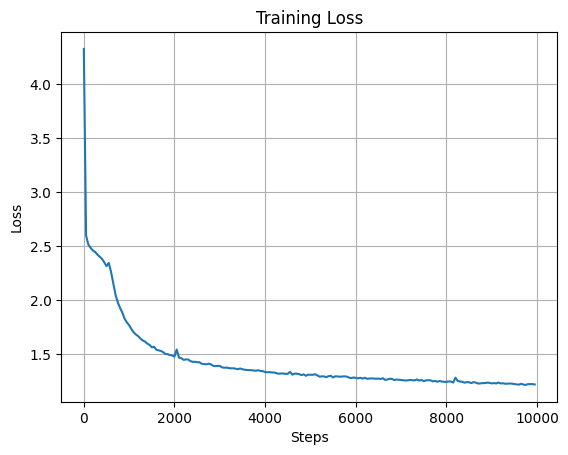

In [3]:
steps = range(0, max_iters-25, 50)
print(losslist)
plt.plot(steps, losslist)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

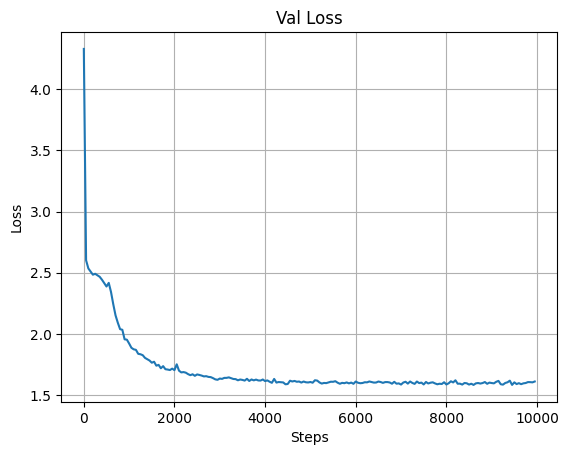

In [4]:
steps = range(0, max_iters-25, 50)

plt.plot(steps, vallist)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Val Loss')
plt.grid(True)
plt.show()

In [5]:
torch.save(model.state_dict(), './save.pth')

In [2]:
model = Transformer()
model.to(device=device)
model.load_state_dict(torch.load('./save.pth'))
model.eval()

Transformer(
  (embedding): Embedding(65, 64)
  (blocks): ModuleList(
    (0-7): 8 x Block(
      (attention): MultiHeadAttention(
        (heads): ModuleList(
          (0-7): 8 x Head(
            (Key): Linear(in_features=64, out_features=64, bias=True)
            (Query): Linear(in_features=64, out_features=64, bias=True)
            (Value): Linear(in_features=64, out_features=64, bias=True)
          )
        )
        (projection): Linear(in_features=512, out_features=64, bias=True)
      )
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ffn): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=64, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=64, bias=True)
        )
      )
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (linear): Linear(in_features=64, out_features=65, bias=Tr

In [3]:
def generate(model):
    start_text = "GONZALO:\nI do well believe your highness; and"
    start_tokens = tokenizer.encode(start_text)
    context = torch.tensor([start_tokens], device=device, dtype=torch.long)
    # context = torch.zeros((1, 1), device=device, dtype=torch.long)
    print(decode(model.generate(context, max_new_tokens=3000)[0].tolist()))

generate(model)

GONZALO:
I do well believe your highness; and there is the sea,
And therefore the countern to the courting of him,
And there is no more to the people to him.

LEONTES:
The stand the statutes of his head and the course,
And then the sea through the course of his head,
And the sea the sea of his soul soul death,
And then the state of his soul souls and strike.

LEONTES:
The stand the state of his souls and the sea true,
And then the state of his soul souls and the sea,
And the state of his soul souls and the sea trutous,
And then he discover of his soul souls streets and to the stones
And the stones of his soul souls and the world and the sea,
And then he dead it out of his soul soul,
And then he be so strange and the sea tribunes,
And the stones of his son of his son head is dead.

HERMIONE:
The shall shall be shed is no so state and the sea,
And then the sea to the sea to the sea of him.

HENRY BOLINGBROKE:
Not then the sea to the court of the court of his son,
And then the court of th